### `BERT` and `TinyBERT`

BERT is designed to pre-train deep bidirectional representations from an unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

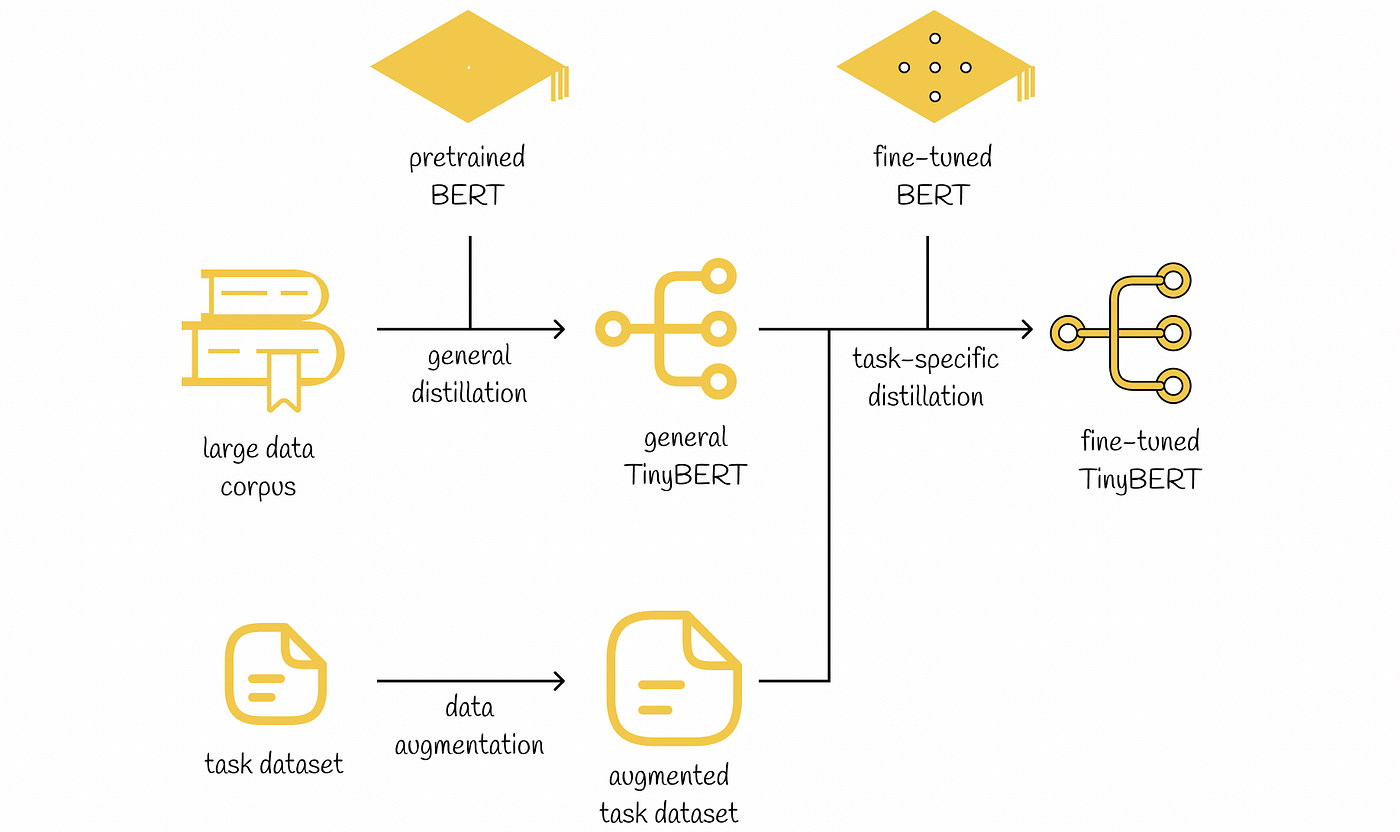

#### Key Points to Remember

- BERT is basically a trained Transformer Encoder stack, with twelve in the Base version, and twenty-four in the Large version, compared to 6 encoder layers in the original Transformer.
- BERT encoders have larger feedforward networks (768 and 1024 nodes in Base and Large respectively) and more attention heads (12 and 16 respectively). BERT was trained on Wikipedia and Book Corpus, a dataset containing +10,000 books of different genres.
- TinyBERT is distilled version of BERT. It uses 4 encoder layers and has 312 embedding size.
- Its easy to train and give high accuracy

##### Disaster or General Tweets Classifications

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd



In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_disaster_tweets.csv", usecols=['text', 'target'])

df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df.isnull().sum()

df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: >

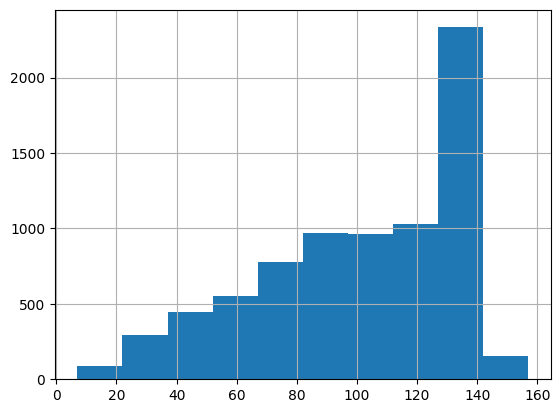

In [9]:
# case, un-cased
# context window -> 512 tokens
# 1 token -> 3char

df['text'].str.len().hist() #-> 160/3 => 53 => 60 tokens




In [10]:
df = df.rename(columns={'target': 'label'})

In [11]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

dataset = dataset.train_test_split(test_size=0.2)

dataset['train'][0]

{'text': 'VIDEO: Virgin Galactic crash: Brakes blamed: Investigators have said a Virgin Galactic spaceship crash was caused by structural failure\x89Û_',
 'label': 1}

In [12]:
id2label = {0:'general', 1: 'disaster'}
label2id = {'general': 0, 'disaster': 1}


##### Data Tokenization


In [13]:
from transformers import AutoTokenizer
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_ckpt = 'huawei-noah/TinyBERT_General_4L_312D'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)


In [14]:
tokenizer(dataset['train'][0]['text'])

def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True, max_length=100)
    return temp

dataset = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|██████████| 1523/1523 [00:00<00:00, 39096.42 examples/s]


In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1523
    })
})

##### Building Model Evaluation Functions
https://huggingface.co/docs/transformers/v4.42.0/en/tasks/sequence_classification#evaluate

In [16]:
# !pip install evaluate

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

#### Model Building


In [17]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(label2id), label2id=label2id, id2label=id2label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
args = TrainingArguments(
    output_dir='train_dir',
    overwrite_output_dir=True,
    num_train_epochs=5,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.484464,0.799081
2,No log,0.452757,0.806960
3,0.502600,0.456817,0.803677
4,0.502600,0.442599,0.811556
5,0.502600,0.444811,0.812213


TrainOutput(global_step=955, training_loss=0.4597768254305056, metrics={'train_runtime': 93.1268, 'train_samples_per_second': 326.973, 'train_steps_per_second': 10.255, 'total_flos': 69927811858800.0, 'train_loss': 0.4597768254305056, 'epoch': 5.0})

In [20]:
trainer.evaluate()

{'eval_loss': 0.44481098651885986,
 'eval_accuracy': 0.8122127380170716,
 'eval_runtime': 1.231,
 'eval_samples_per_second': 1237.201,
 'eval_steps_per_second': 38.993,
 'epoch': 5.0}

## Model Save and Load for Inference


In [21]:
trainer.save_model('tinybert-tweet-classification')

In [23]:
from transformers import pipeline
import torch

data = ['There is a fire in the building', 'I am happy today', 'I am sad today', 
          'I am not feeling well','There is a flood in the city, go to higher ground']

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

classifier = pipeline('text-classification', model='tinybert-tweet-classification', device=device)

classifier(data)

Device set to use cpu


[{'label': 'disaster', 'score': 0.869486927986145},
 {'label': 'general', 'score': 0.891293466091156},
 {'label': 'general', 'score': 0.8796132802963257},
 {'label': 'general', 'score': 0.887087881565094},
 {'label': 'disaster', 'score': 0.8779828548431396}]

##### Push Model to AWS S3

In [24]:
# upload model folder to s3 bucket ml-models/tinybert-sentiment-analysis
import os
import boto3

s3 = boto3.client('s3')
bucket_name = 'mlopsakshdash'

def upload_directory(directory_path, s3_prefix):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file).replace("\\", "/")
            relpath = os.path.relpath(file_path, directory_path)
            s3_key = os.path.join(s3_prefix, relpath).replace("\\", "/")
            
            s3.upload_file(file_path, bucket_name, s3_key)


upload_directory('tinybert-tweet-classification', 'ml-models/tinybert-tweet-classification')